In [14]:
import hopsworks
import pandas as pd
import tensorflow as tf
import joblib

In [15]:
api_key = ""
project = hopsworks.login(project="ID2223HT24G4" )
fs = project.get_feature_store()

2025-01-06 16:35:43,407 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-06 16:35:43,412 INFO: Initializing external client
2025-01-06 16:35:43,413 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 16:35:44,876 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1167511


In [16]:
feature_view = fs.get_feature_view(name="rate_vix_bzf_omx_feature_view", version=1)
data = feature_view.get_batch_data()
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by='date', inplace=True)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.70s) 


In [17]:

latest_30_df = data.tail(30).copy()
latest_30_df = latest_30_df.fillna(method='ffill')

print("Latest 30 rows:\n", latest_30_df)


Latest 30 rows:
                           date      rate        vix          omx        bzf
1430 2024-11-25 00:00:00+00:00  10.96753  14.600000  2512.449951  73.010002
3126 2024-11-26 00:00:00+00:00  11.04977  14.100000  2495.800049  72.809998
3223 2024-11-27 00:00:00+00:00  10.98175  14.100000  2497.679932  72.830002
3522 2024-11-28 00:00:00+00:00  10.91127  14.100000  2508.919922  72.830002
3292 2024-11-29 00:00:00+00:00  10.91541  13.510000  2513.850098  72.940002
2435 2024-12-02 00:00:00+00:00  10.92707  13.340000  2548.129883  71.830002
3082 2024-12-03 00:00:00+00:00  10.98551  13.300000  2573.699951  73.620003
2946 2024-12-04 00:00:00+00:00  10.98574  13.450000  2594.379883  72.309998
261  2024-12-05 00:00:00+00:00  10.92082  13.540000  2606.080078  72.089996
3290 2024-12-06 00:00:00+00:00  10.84800  12.770000  2614.270020  71.120003
2455 2024-12-09 00:00:00+00:00  10.92224  14.190000  2617.800049  72.139999
1311 2024-12-10 00:00:00+00:00  10.90130  14.180000  2595.489990  72.19

In [18]:
mr = project.get_model_registry()
model_versions = mr.get_models("lstm_rate_vix_omx_bzf_7day")
model_to_load = model_versions[-1]  # Load the latest version

model_dir = model_to_load.download()
model_file = model_dir + "/rates_lstm_model.keras"
loaded_model = tf.keras.models.load_model(model_file)

scaler_X_file = model_dir + "/scaler_x.pkl"
scaler_y_file = model_dir + "/scaler_y.pkl"
loaded_scaler_X = joblib.load(scaler_X_file)
loaded_scaler_y = joblib.load(scaler_y_file)

print("Model and scalers loaded successfully!")

Model and scalers loaded successfully!files)... DONE


In [26]:
FEATURE_COLS = ["rate", "vix", "omx", "bzf"]  # Ensure the column order matches training
latest_30_values = latest_30_df[FEATURE_COLS].values  # shape (30, 4)
latest_30_scaled = loaded_scaler_X.transform(latest_30_values)

X_latest = latest_30_scaled.reshape(1, 30, 4)

raw_pred = loaded_model.predict(X_latest)
y_pred_orig = loaded_scaler_y.inverse_transform(raw_pred)  

pred_rate_1day = y_pred_orig[0][0]
pred_rate_7days = y_pred_orig[-1][-1]

print("Predicted rate for 1 day:", pred_rate_1day)
print("Predicted rate for 7 days:", pred_rate_7days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted rate for 1 day: 10.9024515
Predicted rate for 7 days: 10.898581


In [28]:
forecast_df_pred_7days = pd.DataFrame({
    "date": latest_30_df['date'].values[-1] + pd.Timedelta(days=7),
    "pred_rate": pred_rate_7days
}, index=[0])

forecast_df_pred_7days.reset_index(drop=True, inplace=True)

forecast_df_pred_1day = pd.DataFrame({
    "date": latest_30_df['date'].values[-1] + pd.Timedelta(days=1),
    "pred_rate": pred_rate_1day
}, index=[0])

forecast_df_pred_1day.reset_index(drop=True, inplace=True)

forecast_df_pred_1day.columns = ['date', 'rate']
forecast_df_pred_7days.columns = ['date', 'rate']
# Example:
print(forecast_df_pred_1day)
print(forecast_df_pred_7days)

        date       rate
0 2025-01-06  10.902452
        date       rate
0 2025-01-12  10.898581


In [29]:
fg_forcast_1day = fs.get_or_create_feature_group(
    name="rate_vix_forecast_1day",
    version=1,
    description="Forecast for rate and vix for 1 day",
    primary_key=['date'],
)

fg_forcast_7days = fs.get_or_create_feature_group(
    name="rate_vix_forecast_7days",
    version=1,
    description="Forecast for rate and vix for 7 days",
    primary_key=['date'],
)


In [30]:
fg_forcast_1day.insert(forecast_df_pred_1day)
fg_forcast_7days.insert(forecast_df_pred_7days)

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: rate_vix_forecast_1day_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1167511/jobs/named/rate_vix_forecast_1day_1_offline_fg_materialization/executions


Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: rate_vix_forecast_7days_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1167511/jobs/named/rate_vix_forecast_7days_1_offline_fg_materialization/executions


(Job('rate_vix_forecast_7days_1_offline_fg_materialization', 'SPARK'), None)

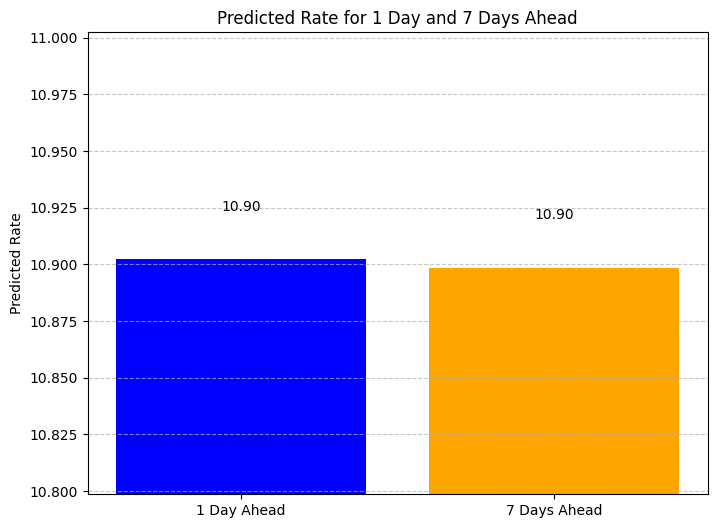

In [34]:
import matplotlib.pyplot as plt
import os

# Directory to save the plot
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

# Create the plot
plt.figure(figsize=(8, 6))
plt.bar(["1 Day Ahead", "7 Days Ahead"], [pred_rate_1day, pred_rate_7days], color=["blue", "orange"])
plt.title("Predicted Rate for 1 Day and 7 Days Ahead")
plt.ylabel("Predicted Rate")
plt.ylim(min(pred_rate_1day, pred_rate_7days) - 0.1, max(pred_rate_1day, pred_rate_7days) + 0.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate the bar with the exact value
for i, value in enumerate([pred_rate_1day, pred_rate_7days]):
    plt.text(i, value + 0.02, f"{value:.2f}", ha="center", va="bottom", fontsize=10)

# Save the plot
plot_file = os.path.join(plot_dir, "predicted_rates.png")
plt.savefig(plot_file, dpi=300, bbox_inches="tight")
plt.show()







Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


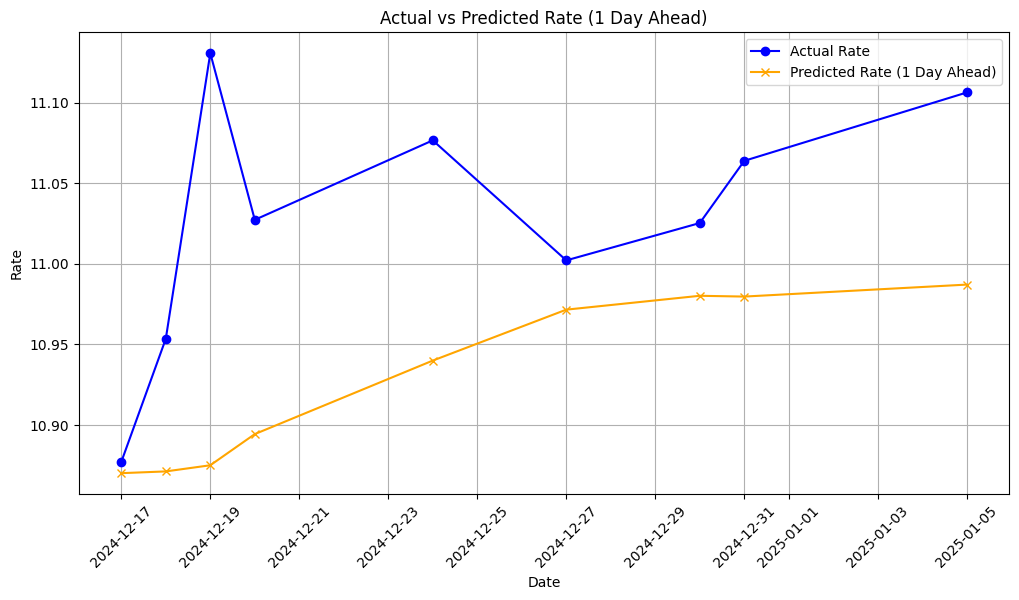

1-Day Actual vs Prediction graph saved to plots/1_day_actual_vs_prediction.png


In [35]:
# Fetch data from the feature groups
# 1-day predictions from "rate_vix_forecast_1day"
rate_vix_forecast_1day_fg = fs.get_feature_group("rate_vix_forecast_1day", version=1)
rate_vix_forecast_1day_df = rate_vix_forecast_1day_fg.read()

# Actual rates from "sek_to_usd"
sek_to_usd_fg = fs.get_feature_group("sek_to_usd", version=1)
sek_to_usd_df = sek_to_usd_fg.read()

# Convert 'date' columns to datetime for both feature groups
rate_vix_forecast_1day_df['date'] = pd.to_datetime(rate_vix_forecast_1day_df['date'])
sek_to_usd_df['date'] = pd.to_datetime(sek_to_usd_df['date'])

# Merge the two dataframes on 'date' for comparison
comparison_df = pd.merge(
    rate_vix_forecast_1day_df, 
    sek_to_usd_df[['date', 'rate']], 
    on="date", 
    how="inner", 
    suffixes=('_predicted', '_actual')
)

# Plot Actual vs Predicted rates
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['date'], comparison_df['rate_actual'], marker='o', label="Actual Rate", color="blue")
plt.plot(comparison_df['date'], comparison_df['rate_predicted'], marker='x', label="Predicted Rate (1 Day Ahead)", color="orange")
plt.title("Actual vs Predicted Rate (1 Day Ahead)")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Save the plot
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, "1_day_actual_vs_prediction.png")
plt.savefig(plot_path)
plt.show()

print(f"1-Day Actual vs Prediction graph saved to {plot_path}")


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.84s) from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (9.63s) from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Reading data from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   Rea

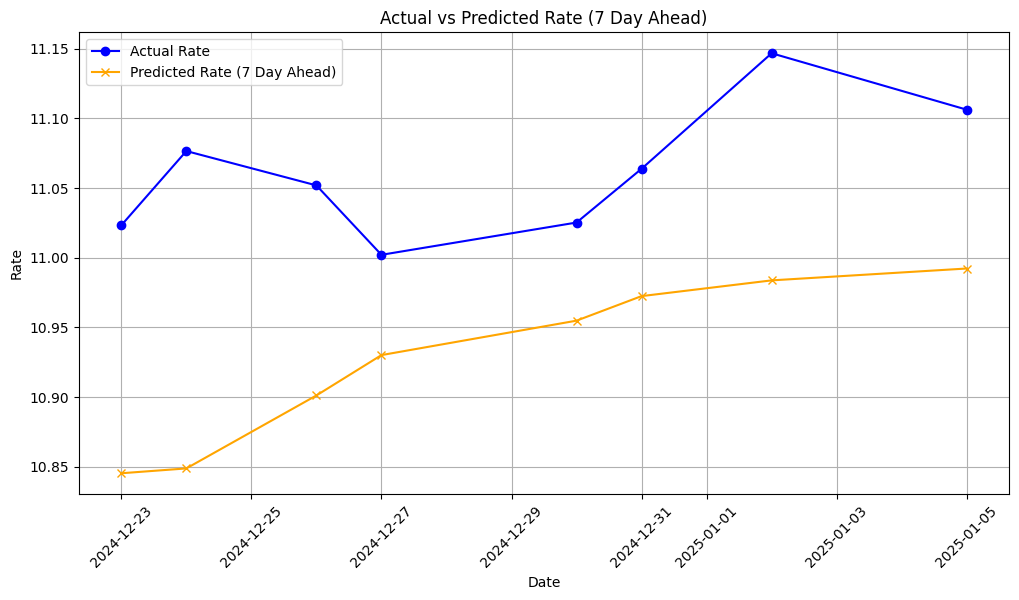

7-Day Actual vs Prediction graph saved to plots/7_day_actual_vs_prediction.png


In [33]:
# Fetch data from the feature groups
# 1-day predictions from "rate_vix_forecast_1day"
rate_vix_forecast_7days_fg = fs.get_feature_group("rate_vix_forecast_7days", version=1)
rate_vix_forecast_7days_df = rate_vix_forecast_7days_fg.read()

# Actual rates from "sek_to_usd"
sek_to_usd_fg = fs.get_feature_group("sek_to_usd", version=1)
sek_to_usd_df = sek_to_usd_fg.read()

# Convert 'date' columns to datetime for both feature groups
rate_vix_forecast_7days_df['date'] = pd.to_datetime(rate_vix_forecast_7days_df['date'])
sek_to_usd_df['date'] = pd.to_datetime(sek_to_usd_df['date'])

# Merge the two dataframes on 'date' for comparison
comparison_df = pd.merge(
    rate_vix_forecast_7days_df, 
    sek_to_usd_df[['date', 'rate']], 
    on="date", 
    how="inner", 
    suffixes=('_predicted', '_actual')
)

# Plot Actual vs Predicted rates
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['date'], comparison_df['rate_actual'], marker='o', label="Actual Rate", color="blue")
plt.plot(comparison_df['date'], comparison_df['rate_predicted'], marker='x', label="Predicted Rate (7 Day Ahead)", color="orange")
plt.title("Actual vs Predicted Rate (7 Day Ahead)")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Save the plot
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, "7_day_actual_vs_prediction.png")
plt.savefig(plot_path)
plt.show()

print(f"7-Day Actual vs Prediction graph saved to {plot_path}")
